In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import add, sub
import pandas as pd

np.random.seed(2017)

Let's generate random 2D data.

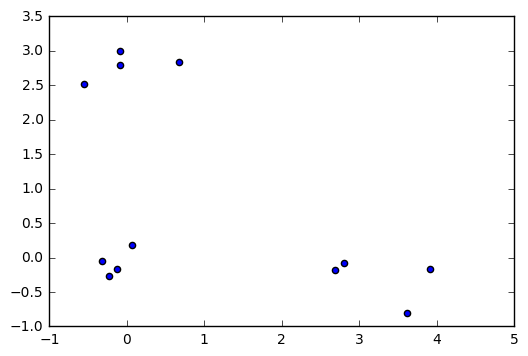

In [42]:
#Data Generation

N = 4
x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

pd.DataFrame(X).to_csv("gaussian_data.csv", sep="\t", header=None, index=True)

Let's compute the similarity matrix.

In [2]:
# As we can't rely on data order in a Map/Reduce paradigm, we add the values' coordinates in each row.
def addCoordinates(row):
    """
    This function adds the matrix coordinates to each value.

    Parameters
    ----------
    row: row of Spark RDD
            This is one row of the current Spark RDD we're parsing.

    Returns
    -------
    result: list
            This is the preprocessed row, with coordinates added.
    """
    
    values = row.split("\t")
    index = int(values[0])
    values = [float(_) for _ in values[1:]]
    result = [[index, j, v] for j, v in enumerate(values)]
    
    return result

def computeSimilarity(row):
    """
    This function adds the matrix coordinates to each value.

    Parameters
    ----------
    row: row of Spark RDD
            This is one row of the current Spark RDD we're parsing.

    Returns
    -------
    similarity: tuple
            This is computed similarity, with matrix coordinates added.
    """
    
    ((i, v1), (j, v2)) = row
    similarity = i, j, -1 * ((v1 - v2) ** 2)
    
    return similarity

def GenerateSimilarityMatrix():
    """
    This method generates the similarity matrix for all the points given to the mapper.

    Parameters
    ----------
    None

    Returns
    -------
    S: Spark RDD
            This is the computed similarity matrix in the Spark RDD format.
    """
    
    # Open the text file and add coordinates to each row
    mat1 = sc.textFile("gaussian_data.csv") 
    new_mat1 = mat1.flatMap(addCoordinates)
    
    # Generate a RDD for x coordinates and one for y coordinates
    new_mat_x = new_mat1.filter(lambda x: x[1] == 0).map(lambda row: (row[0], row[2]))
    new_mat_y = new_mat1.filter(lambda x: x[1] == 1).map(lambda row: (row[0], row[2]))
    
    # Compute the cartesian product for x and y
    mat_cartesian_x = new_mat_x.cartesian(new_mat_x)
    mat_cartesian_y = new_mat_y.cartesian(new_mat_y)
    
    # Compute the similarity for x and y
    sim_x = mat_cartesian_x.map(computeSimilarity)
    sim_y = mat_cartesian_y.map(computeSimilarity)
    
    # Concatenate both x- and y-RDD and sum them by identical keys. Remove cells that equal zero
    sim = sc.union([sim_x, sim_y])
    final = sim.map(lambda row: ((row[0], row[1]), row[2])).reduceByKey(add).filter(lambda x: x[1] != 0)
    
    # Compute the matrix's diagonal
    median = np.median(final.map(lambda row: row[1]).collect())
    print(median)
    diagonal = sc.parallelize(range(mat1.count())).map(lambda x: ((x, x), median))
    
    # Generate the final matrix
    S = sc.union([final, diagonal])
    
    return S

S = GenerateSimilarityMatrix()
#S = sc.parallelize(S.collect())

-9.19047097198


Let's compute the matrix R.

In [3]:
def computeR(A, R, S, N):
    # Compute the sum of A and S
    sumA_S = sc.union([A, S]).reduceByKey(add)

    # Remove all rows where i == k and compute the maximum
    tmp = sc.parallelize(range(N)).cartesian(sumA_S)
    tmp = tmp.map(lambda row: (row[0], (row[1][0][1], (row[1][0][0], row[1][1])))).filter(lambda row: row[1][0] != row[0])
    maximum = tmp.map(lambda row: ((row[1][1][0], row[0]), row[1][1][1])).reduceByKey(max)

    # Compute r
    r = sc.union([S, maximum]).reduceByKey(sub)

    # Compute R
    R = R.join(r).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return R

In [4]:
# Create A and R matrices
A = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
R = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
lambdaValue = 0.5

Let's compute the matrix A.

In [5]:
def computeA(A, R, N):
    """
    if i != k:
        a = min([0, R[k, k] + sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != i and i_prime != k])])
    else:
        a = sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != k])
    """
    
    # Remove all rows where i == k and compute the maximum
    tmp = R.filter(lambda row: row[0][0] != row[0][1])
    tmp = sc.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][0] and row[0] != row[1][0][1])
    tmp = tmp.map(lambda row: ((row[0], row[1][0][1]), row[1][0][0])).join(R)
    maximum = tmp.map(lambda row: ((row[1][0], row[0][1]), max(0, row[1][1]))).reduceByKey(add)
    
    # Add R[k, k]
    tmp = maximum.map(lambda row: ((row[0][1], row[0][1]), row)).join(R.filter(lambda row: row[0][0] == row[0][1]))
    a = tmp.map(lambda row: (row[1][0][0], min(0, row[1][0][1] + row[1][1])))
    
    # Compute the value of a when i == k
    tmp = R.filter(lambda row: row[0][0] == row[0][1])
    tmp = sc.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][1])
    tmp = tmp.map(lambda row: ((row[0], row[1][0][1]), row[1][0][0])).join(R)
    maximum2 = tmp.map(lambda row: ((row[1][0], row[0][1]), max(0, row[1][1]))).reduceByKey(add)

    # Join both RDDs
    a = sc.union([a, maximum2])

    # Compute A
    A = A.join(a).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return A


Let's run the algorithm.

In [6]:
import time

# Create A and R matrices
A = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
R = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
lambdaValue = 0.5

# Start the timer
startTime = time.time()

iterations = 10
for iter in range(iterations):
    if iter % 2 == 0:
        print(iter, "iterations done")
    # Update r(i, k) given a(i, k)
    R = computeR(A, R, S, N)
    
    # Actually execute the code
    R_exec = R.collect()
    R = sc.parallelize(R_exec)
    
    # Update a(i, k) given r(i, k)
    A = computeA(A, R, N)
    
    # Actually execute the code
    A_exec = A.collect()
    A = sc.parallelize(A_exec)    
    
# Stop the timer and print the exectution time
print("Exec: --- %s seconds ---" % (time.time() - startTime))

0 iterations done
2 iterations done
4 iterations done
6 iterations done
8 iterations done
Exec: --- 8211.378233194351 seconds ---


Let's compute the centers.

In [7]:
A_exec

[((3, 7), -1.2061191249909422),
 ((9, 5), -1.2651683063677261),
 ((6, 11), -7.4914654039156634),
 ((9, 2), -0.0086219708449407524),
 ((1, 10), -7.6603148290204341),
 ((3, 0), -5.0323027835143428),
 ((10, 6), -0.0095226002913034839),
 ((4, 4), 5.3824062719354346),
 ((6, 1), -4.2148024044712304),
 ((9, 8), -7.9974738494951758),
 ((3, 10), -7.6603148290204341),
 ((1, 0), -5.3084963327003543),
 ((5, 5), 5.3147466458465153),
 ((11, 11), 0.91296596545398934),
 ((8, 2), -0.0086219708449407524),
 ((0, 10), -7.6603148290204341),
 ((2, 3), -5.8713809477598442),
 ((7, 0), -4.1327464947449322),
 ((4, 9), -0.0076650072758410962),
 ((10, 11), -7.8951672127675936),
 ((0, 4), -1.1313091321840418),
 ((11, 5), -1.2651683063677261),
 ((5, 11), -7.4914654039156634),
 ((5, 0), -4.1327464947449322),
 ((8, 7), -1.2061191249909422),
 ((6, 4), -2.743429735498641),
 ((1, 5), -1.2651683063677261),
 ((9, 10), -7.9766836121035816),
 ((1, 2), -0.18765023411275342),
 ((6, 3), -4.2219691041362601),
 ((3, 8), -7.73264

In [8]:
#Get the centroids
A_matrix = np.zeros((N, N))
R_matrix = np.zeros((N, N))

A_list = A_exec
A_list.sort()

R_list = R_exec
R_list.sort()

for item in A_list:
    A_matrix[item[0][0], item[0][1]] = item[1]
    
for item in R_list:
    R_matrix[item[0][0], item[0][1]] = item[1]

# Combine both a(i, k) and r(i, k) to get centers
centers = [i for i in range(N) if R_matrix[i, i] + A_matrix[i, i] > 0]
centers

[2, 6, 9]

In [10]:
import csv
import numpy as np 
N = 12
file =  open("gaussian_data.csv") #, "rb"
reader = csv.reader(file, delimiter = "\t") #
X = np.zeros(shape=[N, 3])
i = 0
for item in reader:
    X[i] = [item[i] for i in [0,1,2] ]
    i += 1

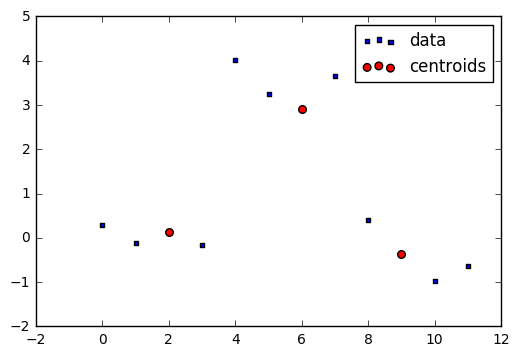

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X[:,0], X[:,1], s=10, c='b', marker="s", label='data')
ax1.scatter(X[centers,0],X[centers,1], s=30, c='r', marker="o", label='centroids')
plt.legend(loc='upper right');
plt.show()